# Human Detection Project

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.feature import hog
from skimage import exposure
from sklearn import svm
from sklearn.decomposition import PCA
from skimage.transform import pyramid_gaussian
import matplotlib.pyplot as plt

# Lectura de imágenes

In [2]:
def leerFotos(path,ini = 0):
    os.chdir(path)
    listaPos = os.listdir()
    fotosDic = {}
    
    for i in range(ini,len(listaPos)+ini):
        fotosDic[i] = cv2.imread(listaPos[i-ini],0)
    return fotosDic

### Fotos Tain 

In [3]:
def duplicaTrain(fotos):
    indx = len(fotos)
    for i in range(len(fotos)):
        fotos[indx+i] = cv2.flip(fotos[i], 1)
        
    return fotos

In [4]:
path = 'C:\\Users\\Jhonny Chicaiza\\Desktop\\Human_Detection_Project-master\\train_pos'
fotosPosTrain0 = leerFotos(path)
fotosPosTrain0 = duplicaTrain(fotosPosTrain0)

path = 'C:\\Users\\Jhonny Chicaiza\\Desktop\\Human_Detection_Project-master\\train_neg'
fotosNegTrainSinTratar = leerFotos(path)

### Fotos Test

In [5]:
path = 'C:\\Users\Jhonny Chicaiza\\Desktop\\Human_Detection_Project-master\\Test\\pos'
fotosTest0 = leerFotos(path)
path = 'C:\\Users\Jhonny Chicaiza\\Desktop\\Human_Detection_Project-master\\Test\\neg'

fotosTest0.update(leerFotos(path,len(fotosTest0)))

### Recorte Train Neg

In [6]:
def generaImagenesRecortadas(dataNeg,winSize,numeroCortesxPh = 20):
    rowsFotoPersona = winSize[0]
    colsFotoPersona = winSize[1]
    
    fotosNegTrain = {}
    for i in range(len(dataNeg)):      
        rowsFotoEntorno = dataNeg[i].shape[0]
        colsFotoEntorno = dataNeg[i].shape[1]
        dimCol = colsFotoEntorno - colsFotoPersona
        dimRow = rowsFotoEntorno - rowsFotoPersona
        
        for j in range(numeroCortesxPh):    
            randRow = random.randint(0,dimRow-1)
            randCol = random.randint(0,dimCol-1)
            randomImage = dataNeg[i][randRow:randRow + rowsFotoPersona ,randCol: randCol + colsFotoPersona]
            fotosNegTrain[j+numeroCortesxPh*i] = randomImage
            
    return fotosNegTrain

# Tratamiento de la imagenes Train

### Ampliazcion Rango Dinámico && Transformacion de Intensidad && Suavizado

Se ha decidido cambiar la dimension de las imagenes de train de 134x70 a 128x64 para recuperar más características

In [7]:
winSize = 128,64

In [8]:
def recortaTrainPos(fotosPos,winSize):
    x,y = fotosPos[0].shape
    
    for i in range(len(fotosPos)):
        incX = (x - winSize[0])//2
        incY = (y - winSize[1])//2    
        fotosPos[i] = fotosPos[i][incX:x-incX,incY:y-incY]
        
    return fotosPos

In [9]:
def ampRangoSet(fotos):
    fotSal = {}
    gamma = 0.35
    
    for i in range(len(fotos)):
        r1 = np.min(fotos[i])
        r2 = np.max(fotos[i])
        fotSal[i] = np.float32(fotos[i])
        fotSal[i] = 255*(fotSal[i]-r1)/(r2-r1)
        fotSal[i] = np.array(255*(fotSal[i] / 255) ** gamma, dtype = 'uint8')
        
    return fotSal

In [10]:
def trataFotos(fotos,kernelSize = 3):
    fotSal = {}
    ## Ampliación del rango
    fotSal = ampRangoSet(fotos)

    ## Suavizado
    n = kernelSize #tamaño del filtro
    sigma = 3 #desviación de la gaussiana
    mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T
    
    for i in range(len(fotSal)):
        fotSal[i] = cv2.filter2D(fotSal[i],-1,mask)
        
    return fotSal

In [11]:
## Tamaño del filtro de suavizado
dimFiltro = 5

fotosPosTrain0 = recortaTrainPos(fotosPosTrain0,winSize)
fotosPosTrain = trataFotos(fotosPosTrain0,dimFiltro)
fotosNegTrainTratadas = trataFotos(fotosNegTrainSinTratar,dimFiltro)
fotosNegTrain = generaImagenesRecortadas(fotosNegTrainTratadas,winSize)

fotosTest = trataFotos(fotosTest0,dimFiltro)

# Extracción de Caracterísitcas

## Hog
    L1
       Normalization using L1-norm.
    L1-sqrt
       Normalization using L1-norm, followed by square root.
    L2
       Normalization using L2-norm.
    L2-Hys
       Normalization using L2-norm, followed by limiting the
       maximum values to 0.2 (`Hys` stands for `hysteresis`) and
       renormalization using L2-norm. (default)

In [12]:
orientations    = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm      = 'L2' 
visualize       = False
visualise       = None
transform_sqrt  = True
feature_vector  = True

In [13]:
def featuresExtrac(imagenes,esPositivo):    
    ## Tamaño del vector
    auxDim = hog(imagenes[0],orientations,pixels_per_cell,cells_per_block,block_norm,visualize,visualise,transform_sqrt,feature_vector)
    tamHog = len(auxDim)
    
    #inicializamos la matriz que guarda los imagenes vectolizados
    fdImagenesHog = np.zeros((len(imagenes),tamHog))
    
    for i in range(len(imagenes)):
        fdImagenesHog[i,:] = hog(imagenes[i],orientations,pixels_per_cell,cells_per_block,block_norm,visualize,visualise,transform_sqrt,feature_vector)
        
    #asignamos el vector de clases(y) 
    if esPositivo:
        y = np.ones((len(imagenes),1))
    else:
        y = np.zeros((len(imagenes),1))

    return fdImagenesHog,y

In [14]:
fdPosTrainHog,yPos = featuresExtrac(fotosPosTrain,1)

In [15]:
fdNegTrainHog,yNeg = featuresExtrac(fotosNegTrain,0)

In [16]:
fdTrainHog = np.vstack((fdPosTrainHog,fdNegTrainHog))
y = np.vstack((yPos,yNeg))


# Entrenamiento del modelo

## HOG Model

In [17]:
clfHog = svm.LinearSVC(C=0.01)
clfHog.fit(fdTrainHog[:,:],y[:,:].ravel())

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [18]:
clfHog.score(fdPosTrainHog,yPos)

0.9893428063943162

In [19]:
clfHog.score(fdNegTrainHog,yNeg)

1.0

# Slide Window

In [20]:
def slidWindow(imagen, winSize,step = 10):
    arrayImagen = []
    
    for i in range(0,imagen.shape[0]- winSize[0],step):        
        for j in range(0,imagen.shape[1]- winSize[1],step):
            arrayImagen.append((i,j,imagen[i:i+ winSize[0], j:j + winSize[1]]))
    
    return arrayImagen

# Pyramid Gaussian

In [21]:
def estudiaFoto(im,winSize,clfHog,ratio = 2,margen = 0):#Ratio de reducción
    # List to store the detections
    hdetections = []
    detectJump = 0;
    
    for scaLev,imScaled in enumerate(pyramid_gaussian(im,downscale=ratio,multichannel=False)):
        if (imScaled.shape[0] >= winSize[0] and imScaled.shape[1] >= winSize[1]):
            for (x,y,imVentana) in slidWindow(imScaled,winSize):
                if (detectJump <= 0):
                    fdHog = hog(imVentana,orientations,pixels_per_cell,cells_per_block,block_norm,visualize,visualise,transform_sqrt,feature_vector);
                    predHog = clfHog.predict(fdHog.reshape(1,-1))
                    acc = clfHog.decision_function(fdHog.reshape(1,-1))[0]
                    
                    if (predHog == 1):
                        hdetections.append((int(x*(ratio**scaLev)),int(y*(ratio**scaLev)),int(winSize[1]*(ratio**scaLev)),int(winSize[0]*(ratio**scaLev)),acc ))
                detectJump -= 1;
    return hdetections

# Supresión No Maximos

### Solapamiento

In [22]:
def overlappingArea(detection_1, detection_2):
    ## Calculo de las coordenadas X Y de la detecciones
    x1_tl,y1_tl,w1,h1,_ = detection_1
    
    x1_br = x1_tl + h1
    y1_br = y1_tl + w1
    
    x2_tl,y2_tl,w2,h2,_ = detection_2
    
    x2_br = x2_tl + h2
    y2_br = y2_tl + w2
    
    
    ## Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br) - max(x1_tl, x2_tl) )
    y_overlap = max(0, min(y1_br, y2_br) - max(y1_tl, y2_tl) )
    
    overlap_area = x_overlap * y_overlap
    area_1 = w1 * h1
    area_2 = w2 * h2
    total_area = area_1 + area_2 - overlap_area
    
    return overlap_area / float(total_area)

In [23]:
def SNoM(detections, umbral  = 0):
    esVacio = not detections
    if (esVacio == True):
        return []
    
    GoodDetec = []
    
    ## Ordenamos las deteciones por coefiente de precision
    detections = sorted(detections, key=lambda detections: detections[4],reverse=True)
    
    GoodDetec.append(detections[0])
    del detections[0]
    
    while esVacio == False:
        for gDetec in GoodDetec:
            if overlappingArea(detections[0], gDetec) > umbral:
                del detections[0]
                break
        else:
            GoodDetec.append(detections[0])
            del detections[0]
        esVacio = not detections

    return GoodDetec

# Prueba del Modelo

En diccionario fotosTest los 50 primeros elemtos son postivos y los 10 ultimos negativos

In [24]:
def showImg(im,text = 'xd'):
    plt.figure(figsize=(7,7))
    plt.title(text)
    plt.imshow(im, cmap = 'gray' )

In [25]:
def muestraResultado(detections,im0, text = "Pedestrains Detected"):
    esVacio = not detections
    if (esVacio == False):
        color = (255)
        im = im0.copy()
        print('Se han detectado',len(detections),'personas en la imagen')
        for (x, y,w, h,_) in detections:
                # Draw the detections
                cv2.rectangle(im, (y, x), (y+w, x+h), color, thickness=2)
        showImg(im,text)
    else:
        showImg(im0,'Don\'t have Pedestrains')

In [26]:
%%time
num = 55
humanDetec = estudiaFoto(fotosTest[num],winSize,clfHog,ratio=2)

Wall time: 791 ms


### Antes de la supresion de no maximos

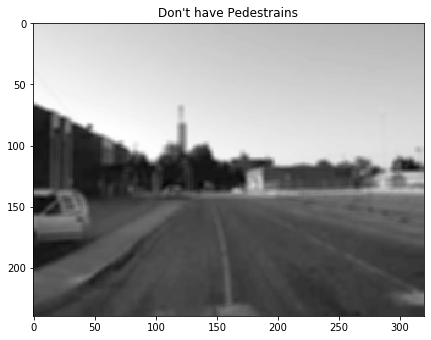

In [27]:
muestraResultado(humanDetec,fotosTest[num])

### Despues de la supresion de no maximos

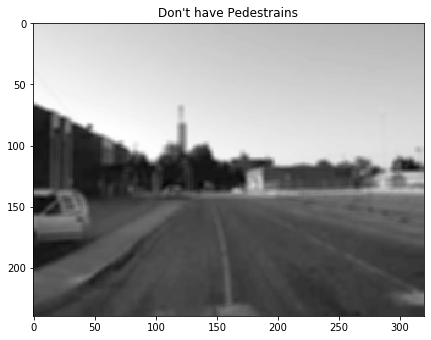

In [28]:
muestraResultado(SNoM(humanDetec,umbral = 0),fotosTest[num])